In [2]:
import numpy as np
import keras
from keras.datasets import fashion_mnist
from matplotlib import pyplot as plt
import math

Using TensorFlow backend.


In [37]:
import wandb

In [39]:
wandb.login()

wandb: Currently logged in as: rishi_m (use `wandb login --relogin` to force relogin)


True

In [3]:
def sigmoid(a):
    s = 1/(1+np.exp(-a))
    return s

def derivative_sigmoid(a):
    ds = sigmoid(a) *(1-sigmoid (a))
    return ds

def tanh(a):
    t=(np.exp(a)-np.exp(-a))/(np.exp(a)+np.exp(-a))
    return t

def derivative_tanh(a):
    dt=1-tanh(a)**2
    return dt


def softmax(a):
    return np.exp(a) / np.sum(np.exp(a), axis=0) #expA (axis=0, keepdims=True)

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = fashion_mnist.load_data()

In [6]:
def one_hot_vector_form(labels,no_neurons_output_layer):
    no_of_examples = labels.shape[0]
    one_hot_vector = np.zeros((no_of_examples , no_neurons_output_layer))
    for i in range(no_of_examples):
        one_hot_vector[i, labels[i]] = 1    
        y = one_hot_vector#.T
    return y  

In [7]:
def initialize_parameters(layer_dimensions):

    #np.random.seed(0)
    parameters = {}
    L = len(layer_dimensions)            # number of layers in the network

    for k in range(1, L):
        
        parameters['w' + str(k)] = np.random.randn(layer_dimensions[k], layer_dimensions[k-1]) 
        parameters['b' + str(k)] = np.zeros((layer_dimensions[k], 1))
        
    return parameters

In [8]:
def initialize_update(layer_dimensions):

    #np.random.seed(0)
    update = {}
    L = len(layer_dimensions)            # number of layers in the network

    for k in range(1, L):
        
        update['update_w' + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1])) 
        update['update_b' + str(k)] = np.zeros((layer_dimensions[k], 1))
        
    return update

In [9]:
def initialize_velocity(layer_dimensions):

    #np.random.seed(0)
    velocity = {}
    L = len(layer_dimensions)            # number of layers in the network

    for k in range(1, L):
        
        velocity['v_w' + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1])) 
        velocity['v_b' + str(k)] = np.zeros((layer_dimensions[k], 1))
        
    return velocity

In [10]:
def initialize_moment(layer_dimensions):

    #np.random.seed(0)
    moment = {}
    L = len(layer_dimensions)            # number of layers in the network

    for k in range(1, L):
        
        moment['m_w' + str(k)] = np.zeros((layer_dimensions[k], layer_dimensions[k-1])) 
        moment['m_b' + str(k)] = np.zeros((layer_dimensions[k], 1))
        
    return moment

In [11]:
def agrregation_forward(h, w, b):
    
    a = np.dot(w, h) + b
    temp = (h,w,b)
    
    return a ,temp

In [12]:
def activation_forward(h_prev, w, b, activation):
        
    
    if activation == "sigmoid":

        a, linear_temp = agrregation_forward(h_prev, w, b)
        h = sigmoid(a)
    
    elif activation == "tanh":
        a, linear_temp = agrregation_forward(h_prev, w, b)
        h = tanh(a)
        
    elif activation == "softmax":
        a, linear_temp = agrregation_forward(h_prev, w, b)
        h = softmax(a)
    
    
    temp = (linear_temp, a)

    return h, temp

In [13]:
def forward_pass(x, parameters):

    temps = []
    h = x
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for k in range(L-1):
        l = k+1
        h_prev = h 
        h,temp = activation_forward(h_prev, parameters['w'+str(l)], parameters['b'+str(l)], activation="sigmoid")
        temps.append(temp)
    
    
    hL,temp1 = activation_forward(h, parameters['w'+str(L)], parameters['b'+str(L)], activation="softmax")
    temps.append(temp1)
    
            
    return hL, temps

In [14]:
def cost_function(yhat, y):   
    m = y.shape[1] # no. of examples
  
    product_sum = np.sum((y *np.log(yhat)), axis = 0)
    cost = -1/m*np.sum(product_sum)
    
    return cost

In [15]:
def agrregation_backward(dL_da, temp):
    
    h_prev, w, b = temp 
    m = h_prev.shape[1]
    dL_dh_prev = np.dot(w.T, dL_da)
    
    dL_dw = 1/m*np.dot(dL_da, h_prev.T)
    dL_db = 1/m*np.sum(dL_da, axis=1, keepdims=True)
     

    return dL_dh_prev, dL_dw, dL_db

In [16]:
def activation_backward(dL_dh, temp, activation):

    linear_temp, a = temp
    
    if activation == "sigmoid":
        ds = derivative_sigmoid(a)
        dL_da = dL_dh * ds
       
        dL_dh_prev, dL_dw, dL_db = agrregation_backward(dL_da, linear_temp)    
        
    elif activation == "tanh":
        dt = derivative_tanh(a)
        dL_da = dL_dh * dt

        dL_dh_prev, dL_dw, dL_db = agrregation_backward(dL_da, linear_temp)    
    
    return dL_dh_prev, dL_dw, dL_db

In [17]:
def backward_pass(yhat, y, temps):
    
    grads = {}
    L = len(temps) # the number of layers
    m = y.shape[1]

# el = one hot vector
    el = y
    dL_dyhat = -(1/yhat)*el
    dL_daL  = -(el - yhat)
    current_temp = temps[L-1]
    linear_tempL,aL = current_temp
    
    hL_prev, wL, bL = linear_tempL
    m = hL_prev.shape[1]

    dL_dhL_prev = np.dot(wL.T, dL_daL)
    
    dL_dwL = 1/m*np.dot(dL_daL, hL_prev.T)
    dL_dbL = 1/m*np.sum(dL_daL, axis=1, keepdims=True)

    grads["dL_dh" + str(L-1)] = dL_dhL_prev
    grads["dL_dw" + str(L)]      = dL_dwL
    grads["dL_db" + str(L)] = dL_dbL
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        #print(l)
        current_temp = temps[l]
        dL_dh_prev, dL_dw, dL_db = activation_backward(grads["dL_dh" + str(l+1)], current_temp, "sigmoid")
        grads["dL_dh" + str(l)] = dL_dh_prev
        grads["dL_dw" + str(l + 1)] = dL_dw
        grads["dL_db" + str(l + 1)] = dL_db

    return grads

In [18]:
def parameter_update_vanilla(parameters, grads,learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)]- learning_rate*grads["dL_dw" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]- learning_rate*grads["dL_db" + str(l + 1)]

    return parameters

In [19]:
def parameter_update_momentum(parameters, grads, update, learning_rate ,gamma):
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        update["update_w" + str(l+1)] = gamma*update["update_w" + str(l+1)] + learning_rate*grads["dL_dw" + str(l + 1)]
        update["update_b" + str(l+1)] = gamma*update["update_b" + str(l+1)] + learning_rate*grads["dL_db" + str(l + 1)]
        
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)]-update["update_w" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]- update["update_b" + str(l+1)]

    return parameters, update

In [20]:
def parameter_update_RMSProp(parameters, grads, velocity, learning_rate ,beta,eps):
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        velocity["v_w" + str(l+1)] = beta*velocity["v_w" + str(l+1)] + (1-beta)*grads["dL_dw" + str(l + 1)]**2
        velocity["v_b" + str(l+1)] = beta*velocity["v_b" + str(l+1)] + (1-beta)*grads["dL_db" + str(l + 1)]**2
        
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)]- (learning_rate / np.sqrt(velocity["v_w" + str(l+1)]+eps))*grads["dL_dw" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]- (learning_rate / np.sqrt(velocity["v_b" + str(l+1)]+eps))*grads["dL_db" + str(l + 1)]

    return parameters, velocity

In [21]:
def parameter_update_adam(parameters, grads, velocity, moment,learning_rate ,beta1,beta2,eps,epoch):
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        
        
        moment["m_w" + str(l+1)] = beta1*moment["m_w" + str(l+1)] + (1-beta1)*grads["dL_dw" + str(l + 1)]
        moment["m_b" + str(l+1)] = beta1*moment["m_b" + str(l+1)] + (1-beta1)*grads["dL_db" + str(l + 1)]
           
        velocity["v_w" + str(l+1)] = beta2*velocity["v_w" + str(l+1)] + (1-beta2)*grads["dL_dw" + str(l + 1)]**2
        velocity["v_b" + str(l+1)] = beta2*velocity["v_b" + str(l+1)] + (1-beta2)*grads["dL_db" + str(l + 1)]**2
        
        m_w_hat = moment["m_w" + str(l+1)]/(1-beta1**(epoch+1))
        m_b_hat = moment["m_b" + str(l+1)]/(1-beta1**(epoch+1))
        
        v_w_hat = velocity["v_w" + str(l+1)]/(1-beta2**(epoch+1))
        v_b_hat = velocity["v_b" + str(l+1)]/(1-beta2**(epoch+1))

        
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)]- ((learning_rate / np.sqrt(velocity["v_w" + str(l+1)]+eps))*m_w_hat)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]- ((learning_rate / np.sqrt(velocity["v_b" + str(l+1)]+eps))*m_b_hat)

    return parameters, velocity, moment

In [22]:
def parameter_update_nadam(parameters, grads, velocity, moment,learning_rate ,beta1,beta2,eps,epoch):
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        
        
        moment["m_w" + str(l+1)] = beta1*moment["m_w" + str(l+1)] + (1-beta1)*grads["dL_dw" + str(l + 1)]
        moment["m_b" + str(l+1)] = beta1*moment["m_b" + str(l+1)] + (1-beta1)*grads["dL_db" + str(l + 1)]
           
        velocity["v_w" + str(l+1)] = beta2*velocity["v_w" + str(l+1)] + (1-beta2)*grads["dL_dw" + str(l + 1)]**2
        velocity["v_b" + str(l+1)] = beta2*velocity["v_b" + str(l+1)] + (1-beta2)*grads["dL_db" + str(l + 1)]**2
        
        m_w_hat = moment["m_w" + str(l+1)]/(1-beta1**(epoch+1))
        m_b_hat = moment["m_b" + str(l+1)]/(1-beta1**(epoch+1))
        
        v_w_hat = velocity["v_w" + str(l+1)]/(1-beta2**(epoch+1))
        v_b_hat = velocity["v_b" + str(l+1)]/(1-beta2**(epoch+1))
        
        
        nadam_update_w =  (beta1*m_w_hat) + (((1-beta1)*grads["dL_dw" + str(l + 1)])/ (1-beta1**(epoch+1)))
        nadam_update_b =  (beta1*m_b_hat) + (((1-beta1)*grads["dL_db" + str(l + 1)])/ (1-beta1**(epoch+1)))

        
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)]- ((learning_rate / np.sqrt(velocity["v_w" + str(l+1)]+eps))*nadam_update_w)                                       
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]- ((learning_rate / np.sqrt(velocity["v_b" + str(l+1)]+eps))*nadam_update_b)

    return parameters, velocity, moment

In [23]:
def find_lookahead_parameters(parameters,update,gamma):
    L = len(parameters) // 2 # number of layers in the neural network
    lookahead_parameters = {}

    for l in range(L):
        lookahead_parameters["w" + str(l+1)] = parameters["w" + str(l+1)]-gamma*update["update_w" + str(l+1)] 
        lookahead_parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-gamma*update["update_b" + str(l+1)]
    return lookahead_parameters 

In [86]:
def predict(x, y, parameters):
    x =x.T
    y =y.T
    
    m = x.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    prob, temps = forward_pass(x, parameters)
    

    predicted_label = np.argmax(prob, axis=0)
    true_label = np.argmax(y, axis=0)
    
    Accuracy = np.sum(predicted_label == true_label)/m
        
#         if probas[0,i] > 0.5:
#             p[0,i] = 1
#         else:
#             p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    #print("Accuracy: "  + str(Accuracy))
        
    return Accuracy

In [87]:
x_train_orig = x_train_orig[:5000]
x_test_orig = x_test_orig[:1000]
y_train_orig = y_train_orig[:5000]
y_test_orig = y_train_orig[:1000]
y_train_orig.shape

(5000,)

In [88]:
x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1)
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1)
x_train = x_train_flatten/255
x_test = x_test_flatten/255

print ("x_train's shape: " + str(x_train.shape))
print ("x_test's shape: " + str(x_test.shape))


x_train's shape: (5000, 784)
x_test's shape: (1000, 784)


In [89]:
# index = 15
# plt.imshow(x_train_orig[index])
# print ("y = " + str(y_train_orig[index])+ ". It's a " + class_names[y_train_orig[index]] +  " picture.")

In [90]:
x_train.shape

(5000, 784)

In [91]:
no_of_training_examples = np.shape(x_train)[0]
no_of_testing_examples = np.shape(x_test)[0]
size_input_layer = [x_train.shape[1]]
no_hidden_layers = 3
size_hidden_layers = [32,32,32]
no_neurons_output_layer = x_train.shape[1] # no of class labels
size_output_layer = [no_neurons_output_layer]   #no_neuron_output = 10


In [92]:
y_train = one_hot_vector_form(y_train_orig,no_neurons_output_layer)
y_test = one_hot_vector_form(y_test_orig,no_neurons_output_layer)
y_train.shape

(5000, 784)

In [93]:
layer_dimensions = size_input_layer + size_hidden_layers + size_output_layer
layer_dimensions

[784, 32, 32, 32, 784]

In [94]:
def get_train_and_validation_loss(x_train,y_train,x_valid,y_valid, parameters):
    xt = x_train.T
    yt = y_train.T
    
    xv = x_valid.T
    yv = y_valid.T

    yhatt, tempst = forward_pass(xt, parameters)
    train_loss = cost_function(yhatt, yt)

    yhatv, tempsv = forward_pass(xv, parameters)
    valid_loss = cost_function(yhatv, yv)

    return train_loss,valid_loss

In [103]:
def L_layer_network(x_train, y_train,x_valid,y_valid,layer_dimensions,learning_rate,num_epochs,gamma = 0.9,  
                    batch_type ="Full_batch",batchsize = 2,grad_descent_type = "Vanilla", beta_rms = 0.9, 
                    beta1 = 0.9,beta2 = 0.999,eps = 1e-8, print_cost=False):
    
    print(learning_rate)

    #np.random.seed(1)
    costs = []          
    
    parameters = initialize_parameters(layer_dimensions)
    update = initialize_update(layer_dimensions)
    velocity = initialize_velocity(layer_dimensions)
    moment = initialize_moment(layer_dimensions)
    if batch_type == "SGD":
        batchsize =1
    elif batch_type ==  "Mini_batch":
        batchsize = batchsize
    elif batch_type == "Full_batch":
        batchsize = x_train.shape[0]
        
    total_examples = x_train.shape[0]
    num_steps = total_examples//batchsize
    #print(num_steps)
 
    for i in range(0, num_epochs):
        print("***********epoch = ",i)
        par_update = 0
        for j in range(num_steps):
            
            start = j*batchsize
            end = start+batchsize
            x = x_train[start:end].T
            y = y_train[start:end].T 
            
            #print("param",parameters)
            #print("in update",update)
               
            if grad_descent_type == "Vanilla":
            
                yhat, temps = forward_pass(x, parameters)
                cost = cost_function(yhat, y)
                grads = backward_pass(yhat,y,temps)
                parameters = parameter_update_vanilla(parameters, grads,learning_rate)
                
            elif grad_descent_type == "Momentum":
                
                yhat, temps = forward_pass(x, parameters)
                cost = cost_function(yhat, y)
                grads = backward_pass(yhat,y,temps)
                #print("in update",update)
                parameters,update = parameter_update_momentum(parameters, grads, update, learning_rate ,gamma)
                #print("out update",update)
                
            elif grad_descent_type == "NAG":
                lookahead_parameters = find_lookahead_parameters(parameters,update,gamma)
                #print("lookahead_parameters",lookahead_parameters)
                yhat, temps = forward_pass(x, lookahead_parameters)
                cost = cost_function(yhat, y)
                grads = backward_pass(yhat,y,temps)
                parameters,update = parameter_update_momentum(parameters, grads, update, learning_rate ,gamma)
                
            elif grad_descent_type == "RMSProp":
                yhat, temps = forward_pass(x, parameters)
                cost = cost_function(yhat, y)
                grads = backward_pass(yhat,y,temps)
                parameters,velocity= parameter_update_RMSProp(parameters, grads, velocity,learning_rate ,beta_rms,eps)
                #print("velocity",velocity)
                
            elif grad_descent_type == "Adam":
                yhat, temps = forward_pass(x, parameters)
                cost = cost_function(yhat, y)
                grads = backward_pass(yhat,y,temps)
                parameters,velocity, moment = parameter_update_adam(parameters, grads, velocity, moment,learning_rate ,beta1,beta2,eps,i)
                #print("velocity",velocity)

            elif grad_descent_type == "Nadam":
                yhat, temps = forward_pass(x, parameters)
                cost = cost_function(yhat, y)
                grads = backward_pass(yhat,y,temps)
                parameters,velocity, moment = parameter_update_nadam(parameters, grads, velocity, moment,learning_rate ,beta1,beta2,eps,i)
                #print("velocity",velocity)   

            #print("out update",update)
            par_update += 1
            
       
        
        #print("par_updated ",par_update,"times")
        #print("***********************************************************")
        
        
    #print("cost in iteration ",i," is =",cost)
                
            # Print the cost every 100 training example
#         if print_cost and i % 2 == 0:
#             print ("Cost after iteration %i: %f" %(i, cost))
#         if print_cost and i % 2 == 0:
#             costs.append(cost)
   
        train_loss,valid_loss = get_train_and_validation_loss(x_train,y_train,x_valid,y_valid, parameters)     

        train_acc= predict(x_train, y_train, parameters)

        valid_acc= predict(x_valid, y_valid, parameters)
        
    
        print("train_acc",train_acc)
        print("valid_acc",valid_acc)
    
        print("train_loss",train_loss)
        print("valid_loss",valid_loss)
    # plot the cost
    
        print("x.shape",x.shape)
        yhat2, temps2 = forward_pass(x_train.T, parameters)
        cost2 = cost_function(yhat2, y_train.T)
        print("loss2",cost2)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters,cost

0.001
***********epoch =  0
loss 13.443076941495713
train_acc 0.0
valid_acc 0.0
train_loss 8.551632970580796
valid_loss 8.691165996724466
x.shape (784, 5000)
loss2 8.551632970580796
***********epoch =  1
loss 8.551632970580796
train_acc 0.0
valid_acc 0.0
train_loss 6.6638265439659445
valid_loss 6.977983621781346
x.shape (784, 5000)
loss2 6.6638265439659445
***********epoch =  2
loss 6.6638265439659445
train_acc 0.0254
valid_acc 0.021
train_loss 5.70051993588494
valid_loss 6.125838759076554
x.shape (784, 5000)
loss2 5.70051993588494


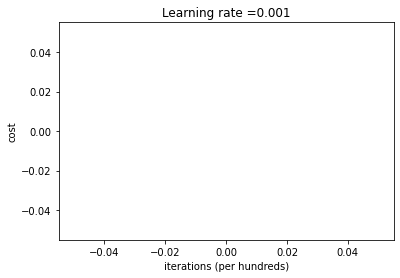

In [104]:
parameters,loss = L_layer_network(x_train, y_train,x_test,y_test,layer_dimensions,0.001,3,batch_type ="Full_batch",batchsize = 10,grad_descent_type = "Nadam",print_cost = True)

In [78]:
loss

0.630187770037902

In [37]:
predict(x_train, y_train, parameters)

Accuracy: 0.8682


In [38]:
predict(x_test,y_test,parameters)

Accuracy: 0.094
